# Part 2: Data Modeling with Seasonal ARIMA (SARIMA)

In this part we will model one of the most popular Time-Series Forecasting model SARIMA, which is the subset of ARIMA.<br>

#   &emsp; &emsp;    A R I M A &emsp; ==> &emsp;    AR   &emsp;     &emsp;     +     &emsp;   &emsp;  MA

###                              &emsp;      &emsp;&emsp;&emsp;&emsp;&emsp;  &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  (Auto Regression)    &emsp;     &emsp;    (Moving Average)
<H3>    &emsp; &emsp;&emsp;       I ==>    Integration </H3>





### Autoregression (AR)
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.<br>

### Moving Average (MA)
A moving average (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. It is also called a moving mean (MM) or rolling mean and is a type of finite impulse response filter.

### Integration (I)
To make the time series stationary (by removing the Trends) by measuring the differences of observations at different time.


### Why not  ARIMA?
Although, Trends from the data can be removed by ARIMA model. But the series can still have seasonal component. Since, our data may have slight seasonal component So we will use SARIMA instead of ARIMA.
<br>

### SARIMA
<br>
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.
<br>

***notation: <b>SARIMA(p,d,q)(P,D,Q,S)</b>*** <br><br>
Here (p,d,q) are Trend parameters and (P,D,Q,S) are seasonal parameters. Let's explore these parameters.<br>
<br><b>Trend parameter<br></b>
p: Trend autoregression order.<br>
d: Trend difference order.<br>
q: Trend moving average order.<br>
<br><b>Seasonal Parameter:<br></b>
P: Seasonal autoregressive order.<br>
D: Seasonal difference order.<br>
Q: Seasonal moving average order.<br>
S: The number of time steps for a single seasonal period.


In [21]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error,  mean_absolute_error
import os

Let us first load our created Train-Test datasets. We have two choices. Either we can load daily data or we can load monthly data. Let's first try daily data. Since we have multiple pollutants data, We will work on PM2.5 dataset first.<br><br>
***It's important to note that our train-test datasets contain Date-Time in first column as string. So, its better to parse them first as dates using pandas parse_dates parameter and set the parsed dates as index.***

In [2]:
# load datasets
train_PM25 = pd.read_csv('dataset/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

In [3]:
# print first few rows
train_PM25.head()

,PM2.5
Date-Time,
2013-03-01,6.458333
2013-03-02,28.750000
2013-03-03,104.750000
2013-03-04,22.875000
2013-03-05,131.833333


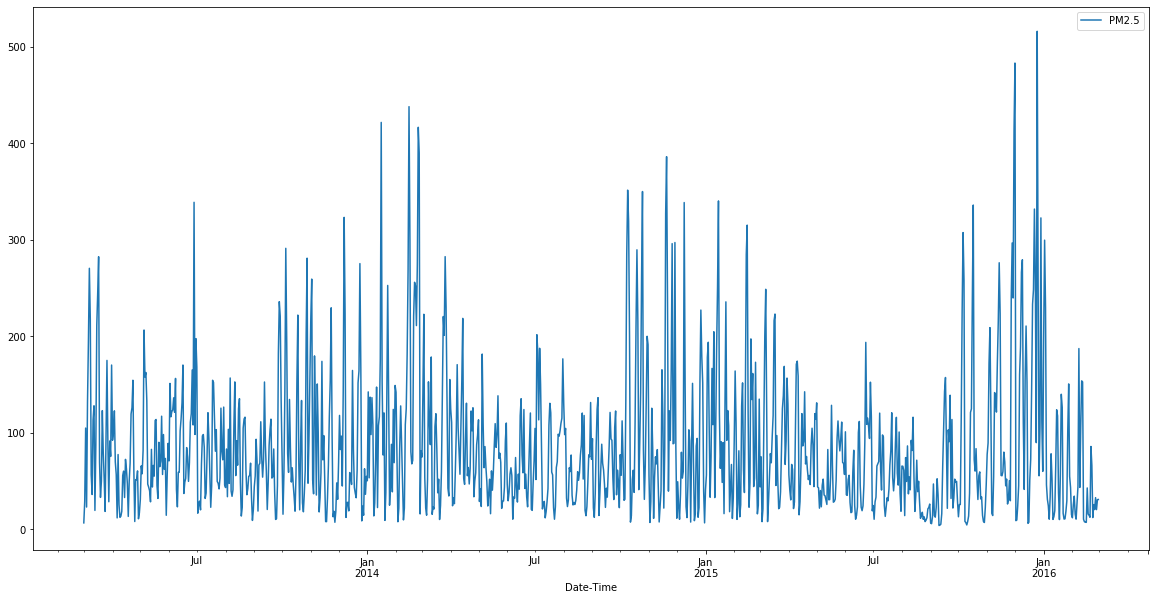

In [4]:
# lets plot our data
train_PM25.plot(figsize = (20,10))

#### Searching for Parameters (p,d,q)(P,D,Q,S) 
In order to best fit SARIMA model into our daily data, we need to find best trend parameters(p, d, q) and Seasonal parameter (P,D,Q,S). Since we have very large daily data, it is not feasible to apply grid search for all possible parameters. So we'll use visual inspection of ACF (Autocorrelation) and PACF(Partial Autocorrelation) plots to find hyper parameters for our SARIMA model. <br>


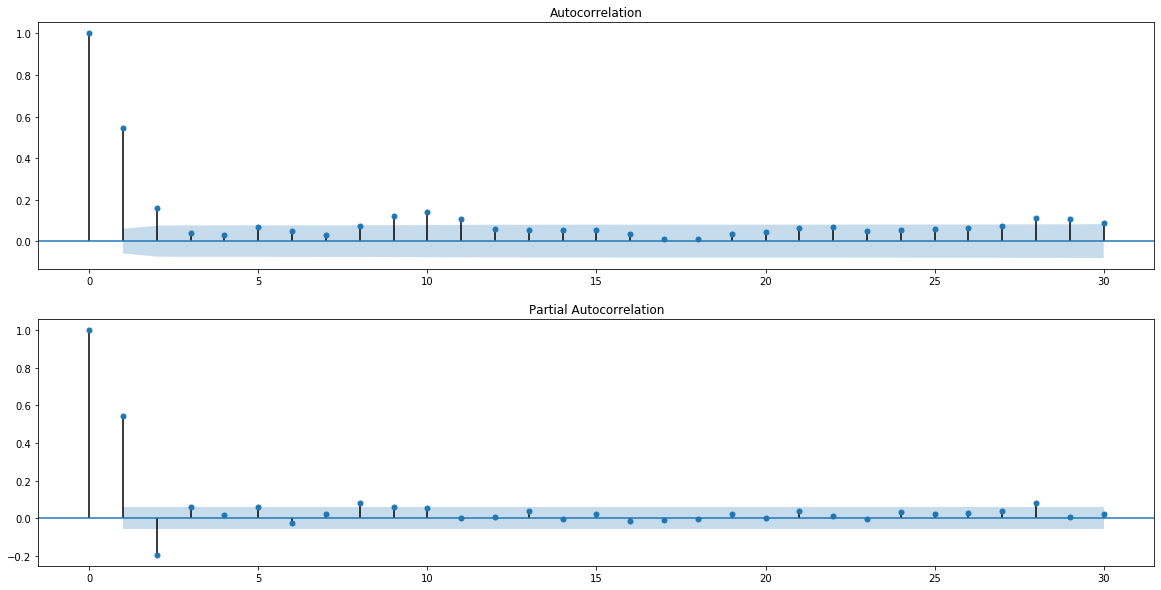

In [5]:
# let us plot acf and pacf graphs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize = (20,10))
plt.subplot(211)
plot_acf(train_PM25, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(train_PM25, ax=plt.gca(), lags = 30)
plt.show()


### Analysing ACF and PACF plots:
We will use Rules for SARIMA model selection from ACF/PACF plots from this site: https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima

#### Rule for identifying d:
<br>
d=0 if the series has no visible trend or ACF at all lags is low.

d≥1 if the series has visible trend or positive ACF values out to a high number of lags.

In our case there is no visible trend and ACF is not low at all lags, So we will take d as 0 and 1.

#### Rule for Identifying the number of AR and MA terms (p and q)
<br>
p is equal to the first lag where the PACF value is above the significance level. So p will be 8.

q is equal to the first lag where the ACF value is above the significance level. So q will be 9.

#### Rule for Identifying the seasonal part of the model:
<br>
S is equal to the ACF lag with the highest value (typically at a high lag), So S may be 10.

D=1 if the series has a stable seasonal pattern over time.

D=0 if the series has an unstable seasonal pattern over time.

Since, In our case there is no stable seasonal pattern visible, So we'll take D = 0

***Rule of thumb: d+D≤2***

P≥1 if the ACF is positive at lag S, else P=0. Since ACF is positive at lag 10, So may take P as 1 or 2

Q≥1 if the ACF is negative at lag S, else Q=0. Since ACF is positive at lag 10, So we'll take Q as 0.

***Rule of thumb: P+Q≤2***

<br>
So, possible values for hyperparameters will be:
<br>
<br>p = 8
<br>d = 0 and 1
<br>q = 9
<br>P = 1 and 2
<br>D = 0
<br>Q = 0
<br>S = 10


In [6]:
# import necessary files for SARIMA model
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")
# lets define hyperparameters for our ARIMA model
p, d, q, P, D, Q, S = 8, (0,1), 9, (1,2), 0, 0, 10
# lets fit the SARIMA model
for each_d in d:
    for each_P in P:
        mod = sm.tsa.statespace.SARIMAX(train_PM25,
                                                        order=(p,each_d,q),
                                                        seasonal_order=(each_P,D,Q,S),
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{} - AIC:{}'.format((p,each_d,q), (each_P,D,Q), results.aic))

ARIMA(8, 0, 9)x(1, 0, 0) - AIC:11943.308771885384
ARIMA(8, 0, 9)x(2, 0, 0) - AIC:11831.777444621817
ARIMA(8, 1, 9)x(1, 0, 0) - AIC:11914.483930087074
ARIMA(8, 1, 9)x(2, 0, 0) - AIC:11808.207161991384


The lowest AIC our model got is 11808.2 in the last model which is a very high value, Let's try to make predictions.

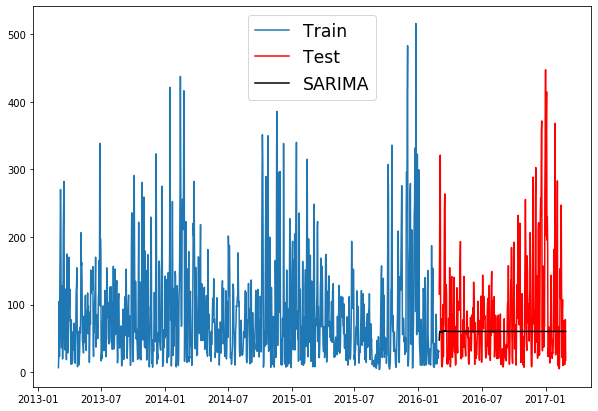

In [7]:
# predicting with SARIMA
sarima_pred = results.predict(start=test_PM25.index[0], end=test_PM25.index[-1])
# plotting the results
plt.figure(figsize=(10, 7))
plt.plot(train_PM25.index, train_PM25, label='Train')
plt.plot(test_PM25.index, test_PM25, label='Test', color='r')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.show()

In [8]:
# let see the what's the root mean square error of this model
mse = mean_squared_error(sarima_pred, test_PM25)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(np.sqrt(mse)))

The Mean Squared Error of our forecasts is 6195.96
The Root Mean Squared Error of our forecasts is 78.71444647171099


 Clearly our model was not able to find Seasonal trend in the data. We can't forecast our predictions with higher AIC value.<br>
Let's us work on our monthly data now and see if we are able to get less AIC value.
#### Loading monthly data

In [9]:
train_PM25 = pd.read_csv('dataset/monthly/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/monthly/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

In [10]:
# print first five rows of train_PM2.5 data
train_PM25.head()

,PM2.5
Date-Time,
2013-03-01,106.770161
2013-04-01,57.350000
2013-05-01,77.247312
2013-06-01,108.320139
2013-07-01,75.435484


In [11]:
# let's see the shape of our train-test data
train_PM25.shape, test_PM25.shape

((36, 1), (12, 1))

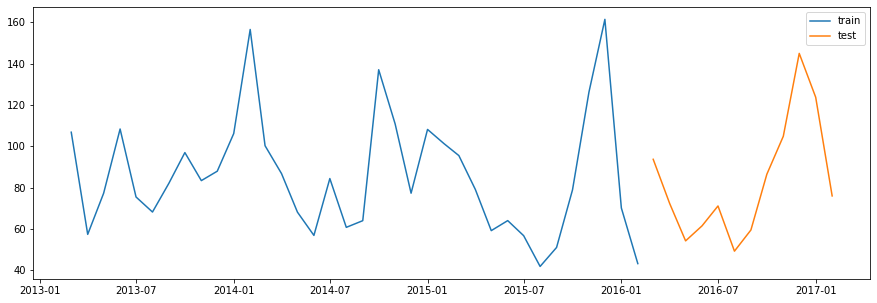

In [12]:
# lets plot the data
plt.figure(figsize = (15,5))
plt.plot(train_PM25)
plt.plot(test_PM25)
plt.legend(['train','test'])

As we can see the data is small. We can perform grid search for searching all possible hyper parameters.

In [13]:
# Function for searching all possible hyperparameters for our SARIMA model
def find_best_sarima(train):
    # initialize min_AIC to a very large value
    min_AIC = 999999999
    # define range for trend parameters Note: Since we have very less data so we'll keep possible range to 2
    p = q = range(2)
    d = range(0,2)
    S = 12 # let's take S as 12 as our data frequency is monthly
    # all combinations of (p,d,q)
    pdq = list(itertools.product(p, d, q))
    # all combinations of seasonal (P,D,Q)
    seasonal_PDQ = [(x[0], x[1], x[2], S) for x in list(itertools.product(p, d, q))]
    best_model = None
    for trend_param in pdq:
        for seasonal_param in seasonal_PDQ:
            try:
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=trend_param,
                                                seasonal_order=seasonal_param,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                if results.aic < min_AIC:
                    min_AIC = results.aic
                    best_model = results
                print('min till now- ',min_AIC)
                print('ARIMA{}x{} - AIC:{}'.format(trend_param, seasonal_param, results.aic))

            except:
                continue
                
    return best_model

In [14]:
best = find_best_sarima(train_PM25)

min till now-  416.2090909272346
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:416.2090909272346
min till now-  229.48985131832055
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:229.48985131832055
min till now-  229.48985131832055
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:237.48172853623927
min till now-  125.1327264424859
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:125.1327264424859
min till now-  125.1327264424859
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:372.3600937725753
min till now-  125.1327264424859
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:221.47712622547832
min till now-  125.1327264424859
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:238.67988692954282
min till now-  122.81469494652407
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:122.81469494652407
min till now-  122.81469494652407
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:333.003309340168
min till now-  122.81469494652407
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:233.27102617693672
min till now-  122.81469494652407
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:229.54776195845787
min till now-  119.61912651929643
ARIMA(0,

Lowest AIC our model got is 110.61450147471821 with parameters (1, 1, 1)x(1, 1, 0, 12). Let's evaluate the model. 

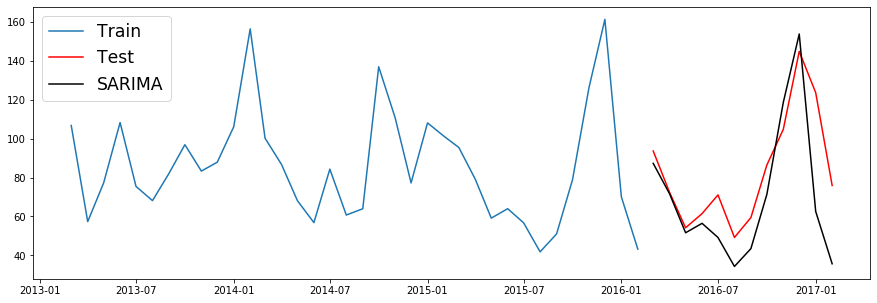

In [15]:
sarima_pred = best.predict(start=test_PM25.index[0], end=test_PM25.index[-1], dynamic=True)
plt.figure(figsize=(15, 5))
plt.plot(train_PM25.index, train_PM25, label='Train')
plt.plot(test_PM25.index, test_PM25, label='Test', color='r')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.show()

In [16]:
mse = mean_squared_error(sarima_pred, test_PM25)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(np.sqrt(mse)))

The Mean Squared Error of our forecasts is 573.5
The Root Mean Squared Error of our forecasts is 23.947900367711377


Now we can fit rest of the monthly pollutants data to the model to make predictions.

In [17]:
# load all monthly datasets
train_PM10 = pd.read_csv('dataset/monthly/train/train_PM10.csv', parse_dates = [0], index_col = [0])
test_PM10 = pd.read_csv('dataset/monthly/test/test_PM10.csv', parse_dates = [0], index_col = [0])
train_SO2 = pd.read_csv('dataset/monthly/train/train_SO2.csv', parse_dates = [0], index_col = [0])
test_SO2 = pd.read_csv('dataset/monthly/test/test_SO2.csv', parse_dates = [0], index_col = [0])
train_NO2 = pd.read_csv('dataset/monthly/train/train_NO2.csv', parse_dates = [0], index_col = [0])
test_NO2 = pd.read_csv('dataset/monthly/test/test_NO2.csv', parse_dates = [0], index_col = [0])
train_CO = pd.read_csv('dataset/monthly/train/train_CO.csv', parse_dates = [0], index_col = [0])
test_CO = pd.read_csv('dataset/monthly/test/test_CO.csv', parse_dates = [0], index_col = [0])
train_O3 = pd.read_csv('dataset/monthly/train/train_O3.csv', parse_dates = [0], index_col = [0])
test_O3 = pd.read_csv('dataset/monthly/test/test_O3.csv', parse_dates = [0], index_col = [0])

In [18]:
# create list of all train-sets
list_train = [train_PM10, train_SO2, train_NO2, train_CO, train_O3]
# create list of all test-sets
list_test = [test_PM10, test_SO2, test_NO2, test_CO, test_O3]
# list for storing best models
list_models = []

# fit models to all pollutants data
for train in list_train:
    print('\n',train.columns.values[0])
    list_models.append(find_best_sarima(train))



 PM10
min till now-  432.9984104383868
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:432.9984104383868
min till now-  233.6551324977142
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:233.6551324977142
min till now-  233.6551324977142
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:242.49800682048388
min till now-  126.37463131735477
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:126.37463131735477
min till now-  126.37463131735477
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:382.86367943386335
min till now-  126.37463131735477
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:218.8537804168632
min till now-  126.37463131735477
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:238.2657179155159
min till now-  123.16459598764636
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:123.16459598764636
min till now-  123.16459598764636
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:328.5661136654453
min till now-  123.16459598764636
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:229.23192141653666
min till now-  123.16459598764636
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:228.76656610632526
min till now-  116.7595141814411


min till now-  609.7119441711884
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:609.7119441711884
min till now-  348.3912963888625
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:348.3912963888625
min till now-  348.3912963888625
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:363.6917445245383
min till now-  188.9602649115255
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:188.9602649115255
min till now-  188.9602649115255
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:556.365640494468
min till now-  188.9602649115255
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:335.4353026608575
min till now-  188.9602649115255
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:364.737746055266
min till now-  188.9602649115255
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:189.96230028808736
min till now-  188.9602649115255
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:519.7052820163235
min till now-  188.9602649115255
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:346.03087849141093
min till now-  188.9602649115255
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:358.87657645142195
min till now-  180.0722244870179
ARIMA(0, 1, 0)x(1, 1


Predictions of  PM10


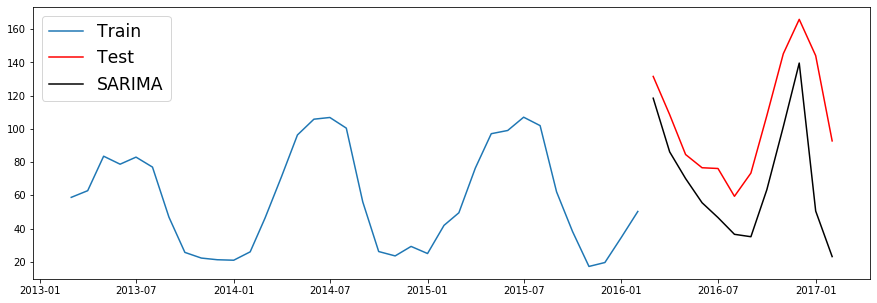


Predictions of  SO2


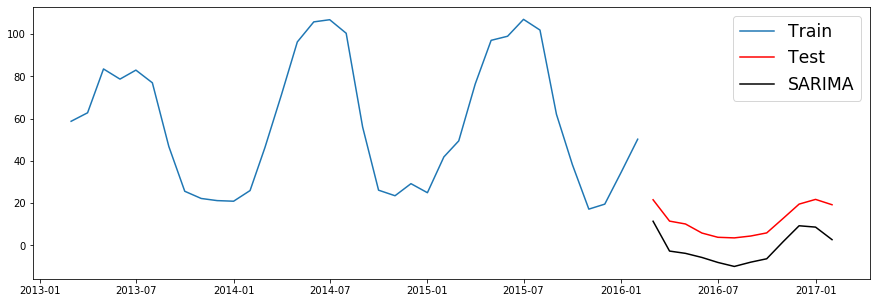


Predictions of  NO2


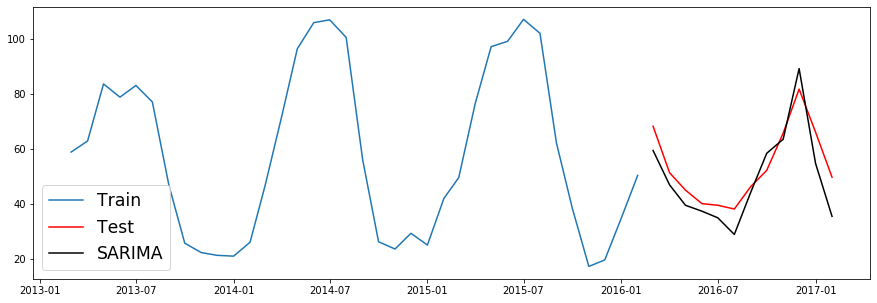


Predictions of  CO


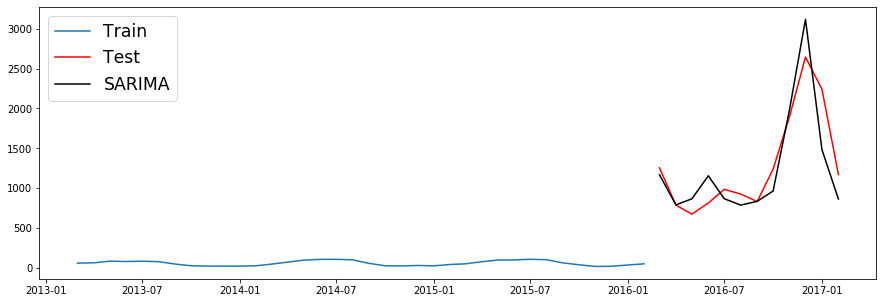


Predictions of  O3


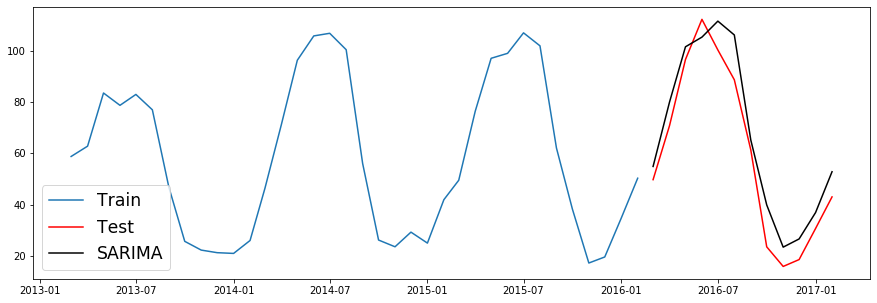

In [19]:
# let's plot all the predictions
for i in range(len(list_models)):
    print('\nPredictions of ',list_test[i].columns.values[0])
    sarima_pred = list_models[i].predict(start=list_test[i].index[0], end=list_test[i].index[-1])
    plt.figure(figsize=(15, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(list_test[i].index, list_test[i], label='Test', color='r')
    plt.plot(sarima_pred.index, sarima_pred, label='SARIMA', color='k')
    plt.legend(loc='best', fontsize='xx-large')
    plt.show()

In [30]:
# lets evaluate all the models
# for explicitly printing previously evaluated PM2.5
sarima_pred = best.predict(start=test_PM25.index[0], end=test_PM25.index[-1])
mse = mean_squared_error(sarima_pred, test_PM25)
mae = mean_absolute_error(sarima_pred, test_PM25)
print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 2)))
print('The Mean Absolute Error of the forecasts is {}'.format(round(mae, 2)))
print('The Root Mean Squared Error of the forecasts is {}'.format(np.sqrt(mse)))

# save results for PM2.5 locally
if not os.path.exists('result'): os.mkdir('result')
if not os.path.exists('result/sarima.csv'):
    # create result dataframe for storing evaluation results(initialized with zeros)
    pd.DataFrame(data = {'EM' : ['mse','mae','rmse'] , 'PM2.5': [0,0,0], 'PM10': [0,0,0],
                                  'SO2': [0,0,0], 'NO2': [0,0,0],
                                  'CO': [0,0,0], 'O3': [0,0,0],

                        }).to_csv('result/sarima.csv',index = False)
# read the lstm.csv file
result = pd.read_csv('result/sarima.csv', dtype = {'EM':str})
# set index as EM (Evaluation Matrix)
result.set_index('EM', inplace = True)
# write all the results
result['PM2.5']['mse'] = mse
result['PM2.5']['mae'] = mae
result['PM2.5']['rmse'] = np.sqrt(mse)

# display successfull write message
print('\nResults for PM2.5 successfully saved to result/sarima.csv')

# for evaluating rest of the models
for i in range(len(list_models)):
    print('\nEvaluation metrics for ',list_test[i].columns.values[0])
    sarima_pred = list_models[i].predict(start=list_test[i].index[0], end=list_test[i].index[-1])
    mse = mean_squared_error(sarima_pred, list_test[i])
    mae = mean_absolute_error(sarima_pred, list_test[i])
    print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 2)))
    print('The Mean Absolute Error of the forecasts is {}'.format(round(mae, 2)))
    print('The Root Mean Squared Error of the forecasts is {}'.format(np.sqrt(mse)))
    
    # write all the results
    result[list_test[i].columns.values[0]]['mse'] = mse
    result[list_test[i].columns.values[0]]['mae'] = mae
    result[list_test[i].columns.values[0]]['rmse'] = np.sqrt(mse)
    
    # display successfull write message
    print('\nResults for {} successfully saved to result/sarima.csv'.format(list_test[i].columns.values[0]))
    
# save the file after writing
result.to_csv('result/sarima.csv')


The Mean Squared Error of the forecasts is 573.5
The Mean Absolute Error of the forecasts is 17.22
The Root Mean Squared Error of the forecasts is 23.947900367711377

Results for PM2.5 successfully saved to result/sarima.csv

Evaluation metrics for  PM10
The Mean Squared Error of the forecasts is 1864.39
The Mean Absolute Error of the forecasts is 36.63
The Root Mean Squared Error of the forecasts is 43.17855326978282

Results for PM10 successfully saved to result/sarima.csv

Evaluation metrics for  SO2
The Mean Squared Error of the forecasts is 160.74
The Mean Absolute Error of the forecasts is 12.56
The Root Mean Squared Error of the forecasts is 12.678493430072013

Results for SO2 successfully saved to result/sarima.csv

Evaluation metrics for  NO2
The Mean Squared Error of the forecasts is 56.33
The Mean Absolute Error of the forecasts is 6.57
The Root Mean Squared Error of the forecasts is 7.505300830367239

Results for NO2 successfully saved to result/sarima.csv

Evaluation metri